In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.backend as K


In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [3]:
# Define paths
BASE_DIR = os.getcwd()
TEST_DIR = os.path.join(BASE_DIR, 'facial-expression-dataset', 'test', 'test/')
TRAIN_DIR = os.path.join(BASE_DIR, 'facial-expression-dataset', 'train', 'train/')



In [17]:
# Load dataset
def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
        print(f"{label} completed")
    return image_paths, labels


In [5]:

# Load train and test data
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)

test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)



angry completed
fear completed
happy completed
surprise completed
disgust completed
sad completed
neutral completed
angry completed
fear completed
happy completed
surprise completed
disgust completed
sad completed
neutral completed


In [6]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train['label'])
test_labels = label_encoder.transform(test['label'])

# Convert labels to categorical
output_class = len(label_encoder.classes_)
y_train = to_categorical(train_labels, num_classes=output_class)
y_test = to_categorical(test_labels, num_classes=output_class)



In [7]:
# Load and preprocess images
def preprocess_images(image_paths):
    images = []
    for img_path in tqdm(image_paths, desc="Loading images"):
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

x_train = preprocess_images(train['image'])
x_test = preprocess_images(test['image'])



Loading images: 100%|██████████| 7178/7178 [00:03<00:00, 2192.81it/s]


In [8]:
# Define input shape
input_shape = (48, 48, 1)




# Train model


In [9]:

# Compute class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [10]:
# Define improved model
model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(output_class, activation='softmax')
])

# Label smoothing
def smooth_labels(y, smooth_factor=0.1):
    return y * (1 - smooth_factor) + (smooth_factor / output_class)

y_train = smooth_labels(y_train)
y_test = smooth_labels(y_test)

# Cosine Annealing Scheduler
def cosine_annealing(epoch, lr, epochs=100, lr_min=1e-6, lr_max=1e-3):
    cos_inner = (np.pi * (epoch % epochs)) / epochs
    return lr_min + (lr_max - lr_min) * (1 + np.cos(cos_inner)) / 2

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_project3.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


2025-05-13 20:25:12.080625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:25:12.123368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:25:12.123428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:25:12.127085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-13 20:25:12.127168: I external/local_xla/xla/stream_executor

In [7]:
history = model.fit(
    x_train, y_train, batch_size=128,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, 
               lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

# Evaluate model


# Save plot of training history


NameError: name 'model' is not defined

In [67]:
from tensorflow.keras.models import load_model

# Load best model từ file
best_model = load_model('best_model_project3.keras')

# Kiểm tra performance
val_loss, val_acc = best_model.evaluate(x_test, y_test)
print(f"Best model - Val Loss: {val_loss}, Val Acc: {val_acc}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6419 - loss: 1.3578
Best model - Val Loss: 1.278541088104248, Val Acc: 0.6688492894172668


In [13]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(f"Improved model - Val Loss: {val_loss}, Val Acc: {val_acc}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6381 - loss: 1.3580
Improved model - Val Loss: 1.278464913368225, Val Acc: 0.6659236550331116


In [1]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('training_accuracy.png')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('training_history.png')

NameError: name 'plt' is not defined

Original image:  fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Predicted label:  fear


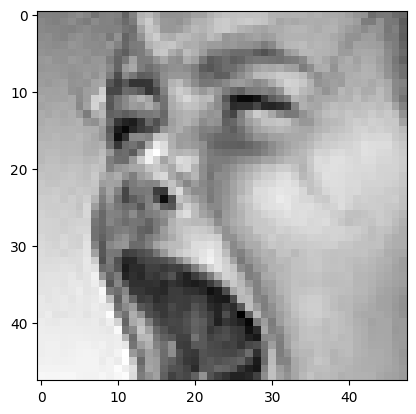

In [71]:
import random
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['label'])  # Giả sử bạn đã có cột 'label' trong tập train

from tensorflow.keras.models import load_model

# Load best model từ file
best_model = load_model('best_model_project3.keras')

image_test = random.randint(0, len(x_test))
print('Original image: ', test['label'][image_test])
pred = best_model.predict(x_test[image_test].reshape(1, 48, 48, 1))
predicted_label = le.inverse_transform([np.argmax(pred)])
print('Predicted label: ', predicted_label[0])
plt.imshow(x_test[image_test].reshape(48, 48), cmap='gray')
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


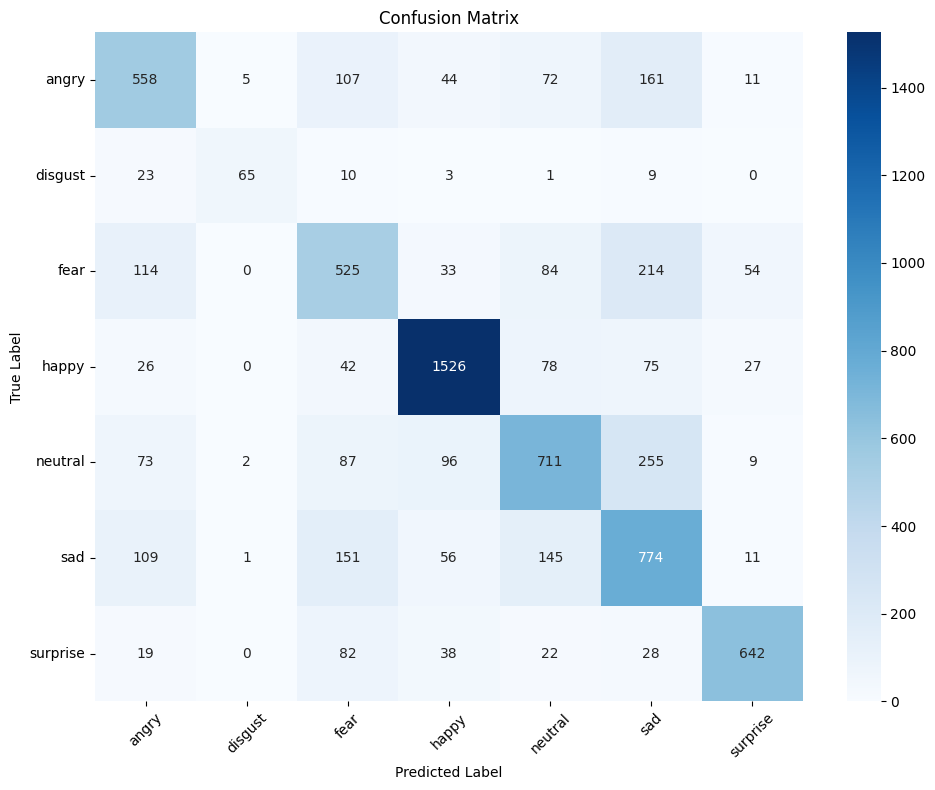

In [72]:
# Import required libraries for confusion matrix
from sklearn.metrics import confusion_matrix


from tensorflow.keras.models import load_model

# Load best model từ file
best_model = load_model('best_model_project3.keras')

# Make predictions on the test set
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert true labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Get emotion labels from the label encoder
emotion_labels = label_encoder.classes_  # ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [73]:
# Import required libraries for metrics
from sklearn.metrics import classification_report

from tensorflow.keras.models import load_model

# Load best model từ file
best_model = load_model('best_model_project3.keras')
# Make predictions on the test set
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert true labels to class labels

# Get emotion labels from the label encoder
emotion_labels = label_encoder.classes_  # ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Compute precision, recall, F1-score, and support
report = classification_report(y_test_classes, y_pred_classes, target_names=emotion_labels, digits=4)

# Print the classification report
print("Classification Report:\n")
print(report)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Classification Report:

              precision    recall  f1-score   support

       angry     0.6052    0.5825    0.5936       958
     disgust     0.8904    0.5856    0.7065       111
        fear     0.5229    0.5127    0.5178      1024
       happy     0.8497    0.8602    0.8549      1774
     neutral     0.6388    0.5766    0.6061      1233
         sad     0.5106    0.6207    0.5603      1247
    surprise     0.8515    0.7726    0.8101       831

    accuracy                         0.6688      7178
   macro avg     0.6956    0.6444    0.6642      7178
weighted avg     0.6761    0.6688    0.6705      7178

